Codage terminé.
Longueur de la chaîne binaire : 21535 bits
Nombre de coefficients non nuls : 6519


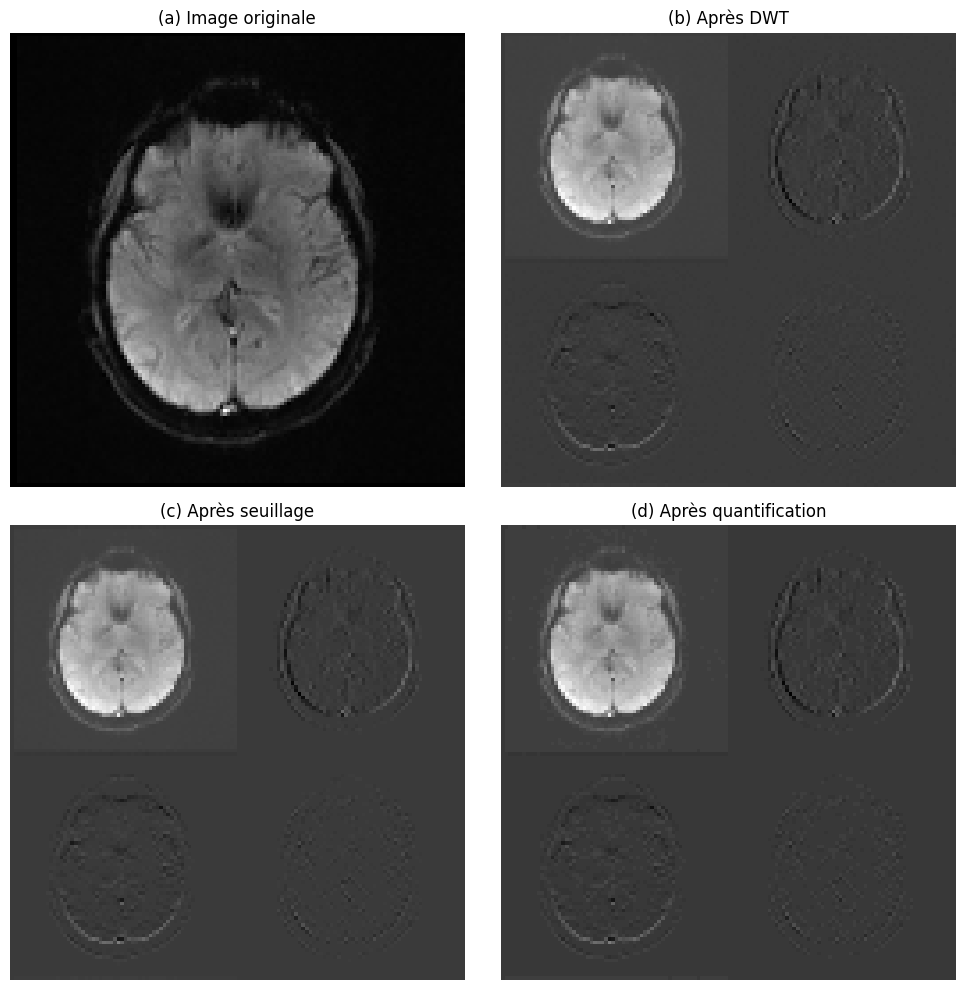

In [1]:
import os
import pydicom
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq
from PIL import Image
def load_image(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == '.dcm':
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array.astype(np.float32)
        image = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
        return image.astype(np.uint8)
    elif ext in ['.jpg', '.jpeg', '.png']:
        image = Image.open(path).convert('L') 
        return np.array(image)
    else:
        raise ValueError(f"Format de fichier non supporté : {ext}")

def apply_dwt(image, wavelet='haar', level=1):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    coeff_array, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_array, coeff_slices, coeffs
def apply_threshold(coeff_array, threshold):
    coeff_array[np.abs(coeff_array) < threshold] = 0
    return coeff_array
def quantize(coeff_array, step=10):
    return np.round(coeff_array / step) * step
def huffman_encode(data):
    freq = Counter(data)
    heap = [[weight, [[symbol, '']]] for symbol, weight in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1]:
            pair[1] = '0' + pair[1]
        for pair in hi[1]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0], lo[1] + hi[1]])

    return dict(sorted(heap[0][1], key=lambda p: (len(p[1]), p[0])))

def encode_quantized_data(quantized_array):
    flat = quantized_array.flatten()
    nonzero_values = flat[flat != 0].astype(int)
    binary_mask = (flat != 0).astype(np.uint8)

    if len(nonzero_values) == 0:
        return '', binary_mask, {}

    huffman_dict = huffman_encode(nonzero_values)
    encoded_stream = ''.join(huffman_dict[val] for val in nonzero_values)
    return encoded_stream, binary_mask, huffman_dict

def plot_results(original, dwt_img, thresholded_img, quantized_img):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(original, cmap='gray')
    axs[0, 0].set_title('(a) Image originale')
    axs[0, 1].imshow(dwt_img, cmap='gray')
    axs[0, 1].set_title('(b) Après DWT')
    axs[1, 0].imshow(thresholded_img, cmap='gray')
    axs[1, 0].set_title('(c) Après seuillage')
    axs[1, 1].imshow(quantized_img, cmap='gray')
    axs[1, 1].set_title('(d) Après quantification')
    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    from PIL import Image

def save_selected_images_and_histograms(original, compressed, output_dir=r"C:\Users\User\Desktop\ArcGIS 10.8(2)"):
    os.makedirs(output_dir, exist_ok=True)

    original_uint8 = np.clip(original, 0, 255).astype(np.uint8)
    Image.fromarray(original_uint8).save(os.path.join(output_dir, "original_image.png"))

    plt.figure()
    plt.hist(original.ravel(), bins=256, color='gray')
    plt.title("Histogramme - Originale")
    plt.xlabel("Intensité")
    plt.ylabel("Nombre de pixels")
    plt.savefig(os.path.join(output_dir, "original_histogramme.png"))
    plt.close()
    
    compressed_uint8 = np.clip(compressed, 0, 255).astype(np.uint8)
    Image.fromarray(compressed_uint8).save(os.path.join(output_dir, "compressed_image.png"))

    plt.figure()
    plt.hist(compressed.ravel(), bins=256, color='blue')
    plt.title("Histogramme - Compressée")
    plt.xlabel("Intensité")
    plt.ylabel("Nombre de pixels")
    plt.savefig(os.path.join(output_dir, "compressed_histogramme.png"))
    plt.close()




if __name__ == "__main__":
    image_path = r"C:\Users\User\Desktop\img123.dcm"  
    image = load_image(image_path)

    dwt_array, slices, coeffs = apply_dwt(image)

    thresholded = apply_threshold(dwt_array.copy(), threshold=4)
    quantized = quantize(thresholded.copy(), step=10)

    encoded_data, binary_mask, huffman_dict = encode_quantized_data(quantized)
    print(f"Codage terminé.")
    print(f"Longueur de la chaîne binaire : {len(encoded_data)} bits")
    print(f"Nombre de coefficients non nuls : {np.sum(binary_mask)}")

    plot_results(image, dwt_array, thresholded, quantized)

    output_dir = r"C:\Users\User\Desktop\ArcGIS 10.8(2)"
    save_selected_images_and_histograms(image, quantized, output_dir)



   

In [2]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

output_dir = "Crypto_AES_Resultats"
encrypted_dir = os.path.join(output_dir, "encrypted_images")
decrypted_dir = os.path.join(output_dir, "decrypted_images")
os.makedirs(encrypted_dir, exist_ok=True)
os.makedirs(decrypted_dir, exist_ok=True)
def pad_image(image):
    h, w = image.shape
    pad_h = (16 - h % 16) if h % 16 != 0 else 0
    pad_w = (16 - w % 16) if w % 16 != 0 else 0
    padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')
    return padded, (pad_h, pad_w)
def unpad_image(image, pad):
    pad_h, pad_w = pad
    return image[:-pad_h or None, :-pad_w or None]
def encrypt_aes(image, key, mode_name):
    padded, pad = pad_image(image)
    image_bytes = padded.tobytes()
    
    mode_dict = {
        "CBC": AES.MODE_CBC,
        "CFB": AES.MODE_CFB,
        "OFB": AES.MODE_OFB,
        "CTR": AES.MODE_CTR
    }
    mode = mode_dict[mode_name]

    if mode_name == "CTR":
        cipher = AES.new(key, mode)
        ciphertext = cipher.encrypt(image_bytes)
        return ciphertext, cipher.nonce, pad
    else:
        iv = get_random_bytes(16)
        cipher = AES.new(key, mode, iv=iv)
        ciphertext = cipher.encrypt(image_bytes)
        return ciphertext, iv, pad

def decrypt_aes(ciphertext, key, iv_or_nonce, shape, mode_name, pad):
    mode_dict = {
        "CBC": AES.MODE_CBC,
        "CFB": AES.MODE_CFB,
        "OFB": AES.MODE_OFB,
        "CTR": AES.MODE_CTR
    }
    mode = mode_dict[mode_name]

    if mode_name == "CTR":
        cipher = AES.new(key, mode, nonce=iv_or_nonce)
    else:
        cipher = AES.new(key, mode, iv=iv_or_nonce)

    decrypted_bytes = cipher.decrypt(ciphertext)
    padded_shape = (shape[0] + pad[0], shape[1] + pad[1])
    decrypted = np.frombuffer(decrypted_bytes, dtype=np.uint8).reshape(padded_shape)
    return unpad_image(decrypted, pad)

key = "MasterSIDI2025".ljust(16, '0').encode('utf-8') 
shape = quantized.shape     

for mode in ["CBC", "CFB", "OFB", "CTR"]:
    print(f"\n Traitement AES mode {mode}...")
    start = time.time()

    start_enc = time.time()
    ciphertext, iv_or_nonce, pad = encrypt_aes(quantized.astype(np.uint8), key, mode)
    end_enc = time.time()
    enc_time = end_enc - start_enc
    print(f"Temps de chiffrement AES-{mode} : {enc_time:.4f} s.")
    
    encrypted_img = np.frombuffer(ciphertext, dtype=np.uint8)
    encrypted_img = encrypted_img[:shape[0] * shape[1]].reshape(shape)  
    encrypted_path = os.path.join(encrypted_dir, f"encrypted_AES_{mode}.png")
    cv2.imwrite(encrypted_path, encrypted_img)

    start_dec = time.time()
    decrypted_img = decrypt_aes(ciphertext, key, iv_or_nonce, shape, mode, pad)
    decrypted_path = os.path.join(decrypted_dir, f"decrypted_AES_{mode}.png")
    cv2.imwrite(decrypted_path, decrypted_img)
    end_dec = time.time()
    dec_time = end_dec - start_dec
    print(f"Temps de déchiffrement AES-{mode} : {dec_time:.4f} s.")

    elapsed = time.time() - start
    print(f"AES-{mode} terminé en {round(elapsed, 4)} s.")
    print(f"Image cryptée : {encrypted_path}")
    print(f"Image déchiffrée : {decrypted_path}")



 Traitement AES mode CBC...
Temps de chiffrement AES-CBC : 0.0009 s.
Temps de déchiffrement AES-CBC : 0.0011 s.
AES-CBC terminé en 0.0036 s.
Image cryptée : Crypto_AES_Resultats\encrypted_images\encrypted_AES_CBC.png
Image déchiffrée : Crypto_AES_Resultats\decrypted_images\decrypted_AES_CBC.png

 Traitement AES mode CFB...
Temps de chiffrement AES-CFB : 0.0010 s.
Temps de déchiffrement AES-CFB : 0.0018 s.
AES-CFB terminé en 0.004 s.
Image cryptée : Crypto_AES_Resultats\encrypted_images\encrypted_AES_CFB.png
Image déchiffrée : Crypto_AES_Resultats\decrypted_images\decrypted_AES_CFB.png

 Traitement AES mode OFB...
Temps de chiffrement AES-OFB : 0.0005 s.
Temps de déchiffrement AES-OFB : 0.0010 s.
AES-OFB terminé en 0.0027 s.
Image cryptée : Crypto_AES_Resultats\encrypted_images\encrypted_AES_OFB.png
Image déchiffrée : Crypto_AES_Resultats\decrypted_images\decrypted_AES_OFB.png

 Traitement AES mode CTR...
Temps de chiffrement AES-CTR : 0.0004 s.
Temps de déchiffrement AES-CTR : 0.0010 

In [3]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
def compute_npcr_uaci(img1, img2):
    diff = img1 != img2
    npcr = np.sum(diff) / diff.size * 100
    uaci = np.mean(np.abs(img1.astype(np.int16) - img2.astype(np.int16))) / 255 * 100
    return npcr, uaci
def plot_histogram(image, title, path):
    plt.figure()
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='black')
    plt.title(f"Histogramme - {title}")
    plt.xlabel("Intensité")
    plt.ylabel("Nombre de pixels")
    plt.savefig(path)
    plt.close()
def plot_correlation(image, title, path):
    h, w = image.shape
    x = image[:, :-1].ravel()
    y = image[:, 1:].ravel()
    plt.figure()
    plt.scatter(x, y, s=1, alpha=0.5)
    plt.title(f"Corrélation - {title}")
    plt.xlabel("Pixel(i)")
    plt.ylabel("Pixel(i+1)")
    plt.savefig(path)
    plt.close()
def calculate_entropy(image):
    hist = np.histogram(image.flatten(), bins=256, range=(0, 256))[0]
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)
for mode in ["CBC", "CFB", "OFB", "CTR"]:
    print(f"\nÉvaluation de la qualité pour AES-{mode}...")
    decrypted_path = os.path.join(decrypted_dir, f"decrypted_AES_{mode}.png")
    encrypted_path = os.path.join(encrypted_dir, f"encrypted_AES_{mode}.png")
    decrypted_img = cv2.imread(decrypted_path, cv2.IMREAD_GRAYSCALE)
    encrypted_img = cv2.imread(encrypted_path, cv2.IMREAD_GRAYSCALE)
    quantized_uint8 = quantized.astype(np.uint8)
    decrypted_img = decrypted_img.astype(np.uint8)
    encrypted_img = encrypted_img.astype(np.uint8)
    val_psnr = psnr(quantized_uint8, decrypted_img, data_range=255)
    val_ssim = ssim(quantized_uint8, decrypted_img, data_range=255)
    print(f"PSNR : {val_psnr:.2f} dB")
    print(f"SSIM : {val_ssim:.4f}")
    npcr, uaci = compute_npcr_uaci(quantized_uint8, encrypted_img)
    print(f"NPCR : {npcr:.2f}%")
    print(f"UACI : {uaci:.2f}%")
    ent = calculate_entropy(encrypted_img)
    print(f"Entropie (image chiffrée) : {ent:.4f} bits")
    hist_path = os.path.join(output_dir, f"hist_AES_{mode}.png")
    plot_histogram(encrypted_img, f"AES-{mode}", hist_path)
    print(f"Histogramme enregistré : {hist_path}")
    corr_path = os.path.join(output_dir, f"corr_AES_{mode}.png")
    plot_correlation(encrypted_img, f"AES-{mode}", corr_path)
    print(f"Corrélation enregistrée : {corr_path}")



Évaluation de la qualité pour AES-CBC...
PSNR : inf dB
SSIM : 1.0000
NPCR : 99.66%
UACI : 47.22%
Entropie (image chiffrée) : 7.9897 bits


C:\Users\User\anaconda3\envs\project\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


Histogramme enregistré : Crypto_AES_Resultats\hist_AES_CBC.png
Corrélation enregistrée : Crypto_AES_Resultats\corr_AES_CBC.png

Évaluation de la qualité pour AES-CFB...
PSNR : inf dB
SSIM : 1.0000
NPCR : 99.63%
UACI : 47.28%
Entropie (image chiffrée) : 7.9883 bits
Histogramme enregistré : Crypto_AES_Resultats\hist_AES_CFB.png
Corrélation enregistrée : Crypto_AES_Resultats\corr_AES_CFB.png

Évaluation de la qualité pour AES-OFB...
PSNR : inf dB
SSIM : 1.0000
NPCR : 99.66%
UACI : 47.02%
Entropie (image chiffrée) : 7.9896 bits
Histogramme enregistré : Crypto_AES_Resultats\hist_AES_OFB.png
Corrélation enregistrée : Crypto_AES_Resultats\corr_AES_OFB.png

Évaluation de la qualité pour AES-CTR...
PSNR : inf dB
SSIM : 1.0000
NPCR : 99.59%
UACI : 46.86%
Entropie (image chiffrée) : 7.9885 bits
Histogramme enregistré : Crypto_AES_Resultats\hist_AES_CTR.png
Corrélation enregistrée : Crypto_AES_Resultats\corr_AES_CTR.png


In [4]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import pydicom
import pywt
base_dir = "Crypto_AES_Resultats"
encrypted_dir = os.path.join(base_dir, "encrypted_images")
decrypted_dir = os.path.join(base_dir, "decrypted_images")
os.makedirs(encrypted_dir, exist_ok=True)
os.makedirs(decrypted_dir, exist_ok=True)
def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array.astype(np.float32)
    image = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
    return image.astype(np.uint8)

def apply_dwt(image, wavelet='haar', level=2):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    coeff_array, _ = pywt.coeffs_to_array(coeffs)
    return coeff_array

def apply_threshold(coeff_array, threshold=10):
    coeff_array[np.abs(coeff_array) < threshold] = 0
    return coeff_array

def quantize(coeff_array, step=10):
    return np.round(coeff_array / step) * step
def pad_image(image):
    h, w = image.shape
    pad_h = (16 - h % 16) if h % 16 != 0 else 0
    pad_w = (16 - w % 16) if w % 16 != 0 else 0
    padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')
    return padded, (pad_h, pad_w)
def unpad_image(image, pad):
    pad_h, pad_w = pad
    return image[:-pad_h or None, :-pad_w or None]
def encrypt_aes(image, key, mode_name):
    padded, pad = pad_image(image)
    image_bytes = padded.tobytes()
    mode_dict = {
        "CBC": AES.MODE_CBC,
        "CFB": AES.MODE_CFB,
        "OFB": AES.MODE_OFB,
        "CTR": AES.MODE_CTR
    }
    mode = mode_dict[mode_name]

    if mode_name == "CTR":
        cipher = AES.new(key, mode)
        ciphertext = cipher.encrypt(image_bytes)
        return ciphertext, cipher.nonce, pad
    else:
        iv = get_random_bytes(16)
        cipher = AES.new(key, mode, iv=iv)
        ciphertext = cipher.encrypt(image_bytes)
        return ciphertext, iv, pad

def decrypt_aes(ciphertext, key, iv_or_nonce, shape, mode_name, pad):   
    mode_dict = {
        "CBC": AES.MODE_CBC,
        "CFB": AES.MODE_CFB,
        "OFB": AES.MODE_OFB,
        "CTR": AES.MODE_CTR
    }
    mode = mode_dict[mode_name]

    if mode_name == "CTR":
        cipher = AES.new(key, mode, nonce=iv_or_nonce)
    else:
        cipher = AES.new(key, mode, iv=iv_or_nonce)

    decrypted_bytes = cipher.decrypt(ciphertext)
    padded_shape = (shape[0] + pad[0], shape[1] + pad[1])
    decrypted = np.frombuffer(decrypted_bytes, dtype=np.uint8).reshape(padded_shape)
    return unpad_image(decrypted, pad)
def compute_npcr_uaci(img1, img2):
    diff = img1 != img2
    npcr = np.sum(diff) / diff.size * 100
    uaci = np.mean(np.abs(img1.astype(np.int16) - img2.astype(np.int16))) / 255 * 100
    return npcr, uaci
def calculate_entropy(image):
    hist = np.histogram(image.flatten(), bins=256, range=(0, 256))[0]
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)
def correlation_coefficient(img1, img2):
    img1_flat = img1.flatten().astype(np.float32)
    img2_flat = img2.flatten().astype(np.float32)
    return np.corrcoef(img1_flat, img2_flat)[0, 1]

dicom_path = "C:\\Users\\User\Desktop\\img123.dcm"  
image = load_dicom_image(dicom_path)
dwt_array = apply_dwt(image)
thresholded = apply_threshold(dwt_array.copy(), threshold=10)
quantized = quantize(thresholded.copy(), step=10).astype(np.uint8)
shape = quantized.shape

key = get_random_bytes(16)

results = []

for mode in ["CBC", "CFB", "OFB", "CTR"]:
    print(f"\nTraitement AES-{mode}...")
    start = time.time()
    
    ciphertext, iv_or_nonce, pad = encrypt_aes(quantized, key, mode)
    encrypted_img = np.frombuffer(ciphertext, dtype=np.uint8)[:shape[0] * shape[1]].reshape(shape)
    cv2.imwrite(os.path.join(encrypted_dir, f"encrypted_AES_{mode}.png"), encrypted_img)
    decrypted_img = decrypt_aes(ciphertext, key, iv_or_nonce, shape, mode, pad)
    cv2.imwrite(os.path.join(decrypted_dir, f"decrypted_AES_{mode}.png"), decrypted_img)
    elapsed = time.time() - start
    val_psnr = psnr(quantized, decrypted_img, data_range=255)
    val_ssim = ssim(quantized, decrypted_img, data_range=255)
    npcr, uaci = compute_npcr_uaci(image, encrypted_img)
    ent = calculate_entropy(encrypted_img)
    corr = correlation_coefficient(quantized, decrypted_img)
    results.append([mode, round(elapsed, 4), round(val_psnr, 2), round(val_ssim, 4), round(npcr, 2), round(uaci, 2),round(ent, 4),round(corr, 4)])
import pandas as pd
df = pd.DataFrame(results, columns=["Mode", "Temps (s)", "PSNR (dB)", "SSIM", "NPCR (%)", "UACI (%)", "Entropie","Corrélation"])
print("\nRésultats comparatifs des modes AES :")
print(df.to_markdown(index=False))



Traitement AES-CBC...

Traitement AES-CFB...

Traitement AES-OFB...

Traitement AES-CTR...

Résultats comparatifs des modes AES :
| Mode   |   Temps (s) |   PSNR (dB) |   SSIM |   NPCR (%) |   UACI (%) |   Entropie |   Corrélation |
|:-------|------------:|------------:|-------:|-----------:|-----------:|-----------:|--------------:|
| CBC    |      0.0037 |         inf |      1 |      99.67 |      40.86 |     7.9888 |             1 |
| CFB    |      0.005  |         inf |      1 |      99.65 |      41.54 |     7.9893 |             1 |
| OFB    |      0.0031 |         inf |      1 |      99.7  |      41.13 |     7.9885 |             1 |
| CTR    |      0.0043 |         inf |      1 |      99.57 |      41.41 |     7.9891 |             1 |
